# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset represents 17 marketing campaigns conducted by the Portuguese bank between May 2008 and November 2010.

These campaigns involved a total of 79,354 customer contacts, during which a long-term deposit product was offered. Out of all contacts, 6,499 resulted in successful subscriptions, corresponding to an 8% success rate.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [4]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn datasets and models
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Preprocessing and feature engineering
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error

In [5]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
print("=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print("Columns:", df.columns.tolist(), "\n")

print("=== Data Types ===")
print(df.dtypes, "\n")

print("=== Missing Values (NaN) ===")
na_counts = df.isna().sum()
if na_counts.sum() > 0:
    print(na_counts[na_counts > 0])
else:
    print("No NaN values found.")
print()

# ----- 'Unknown' Values in Categorical Features -----
print("=== 'Unknown' Values in Categorical Features ===")
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']

for col in categorical_cols:
    count_unknown = (df[col] == 'unknown').sum()
    if count_unknown > 0:
        pct = (count_unknown / len(df)) * 100
        print(f"{col}: {count_unknown} unknown values ({pct:.1f}%)")

print()


=== Dataset Overview ===
Shape: (41188, 21)
Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'] 

=== Data Types ===
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object 

=== Missing Values (NaN) ===
No NaN values found.

=== 'Unknown' Values in Categorical Features ===
job: 330 unknown va

**Analysis summary: **

There are no explicit missing values, but several categorical variables (job, marital, education, default, housing, loan) include the category “unknown”, which represents missing information and should be handled accordingly.

All numeric variables are already numeric and do not require coercion.

The following features should be converted to categorical data types (since they are qualitative):
job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, and the target y.


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

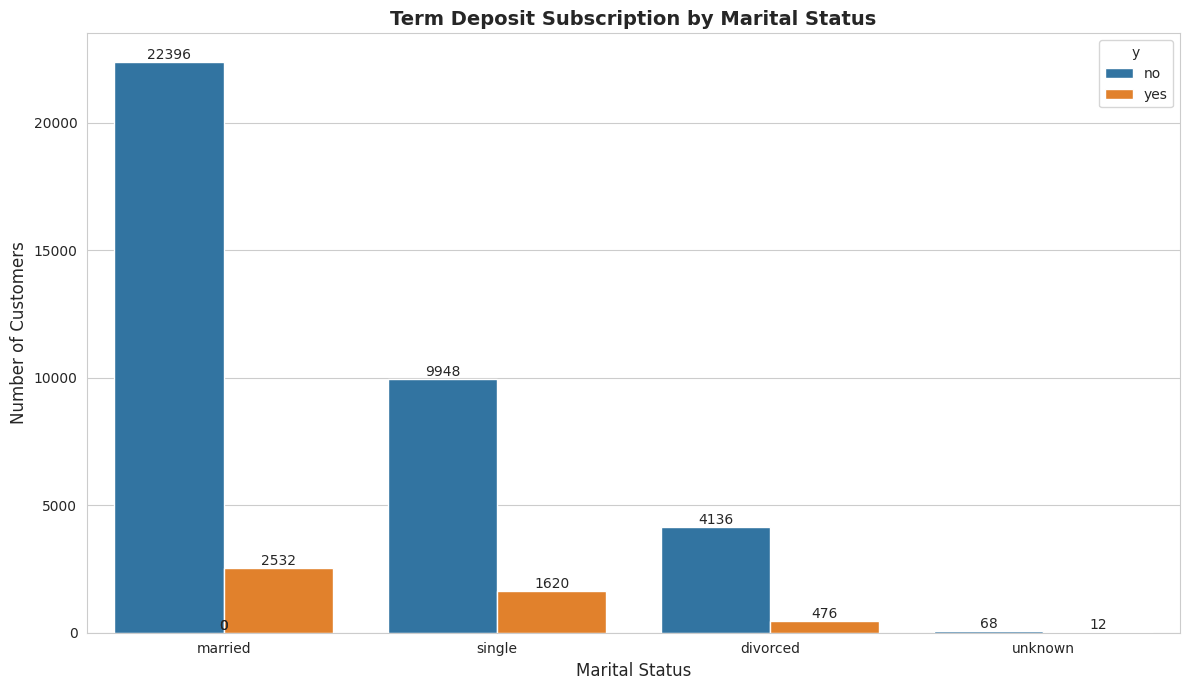

In [9]:
# Bar Chart: Marital Status vs. Term Deposit Subscription

# Set plot style and size
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create count plot
ax = sns.countplot(data=df, x="marital", hue="y")

# Add title and axis labels
ax.set_title("Term Deposit Subscription by Marital Status", fontsize=14, fontweight="bold")
ax.set_xlabel("Marital Status", fontsize=12)
ax.set_ylabel("Number of Customers", fontsize=12)

# Annotate bar heights
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f"{height:.0f}",
                (bar.get_x() + bar.get_width() / 2, height),
                ha="center", va="bottom", fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


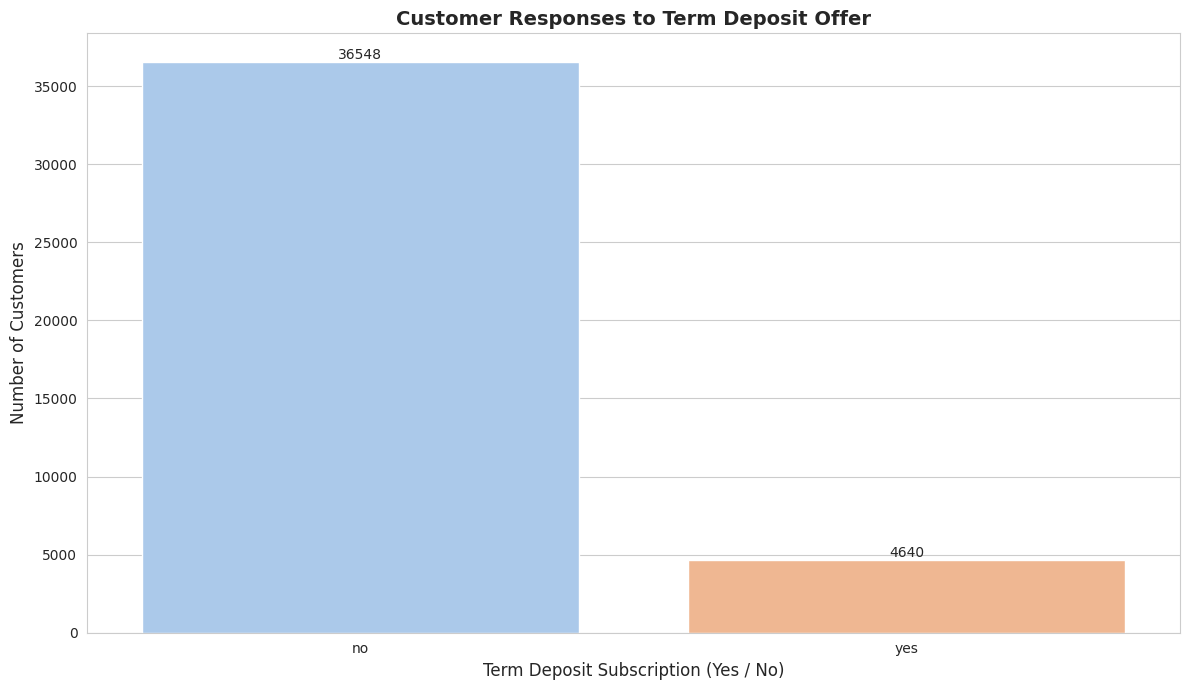

In [10]:
# Bar Plot: Term Deposit Subscription Count

# Set figure size and style
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Create count plot
ax = sns.countplot(data=df, x="y", hue="y", palette="pastel")

# Add title and labels
ax.set_title("Customer Responses to Term Deposit Offer", fontsize=14, fontweight="bold")
ax.set_xlabel("Term Deposit Subscription (Yes / No)", fontsize=12)
ax.set_ylabel("Number of Customers", fontsize=12)

# Annotate bar heights
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f"{height:.0f}",
                (bar.get_x() + bar.get_width() / 2, height),
                ha="center", va="bottom", fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


**Business Objective:**

The objective is to develop and compare predictive models that can accurately identify whether a client will subscribe to a term deposit based on their demographic, financial, and campaign-related information. By understanding which factors most influence a client’s decision, the bank can optimize future marketing campaigns, improve targeting efficiency, and increase the overall success rate of term deposit subscriptions.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [11]:
# Create a dataset with bank features

features = [
    'age', 'job', 'marital', 'education', 'default', 'housing',
    'loan', 'contact'
]


X = df[features]
y = df['y']

X.head(10)
print(y)

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41188, dtype: object


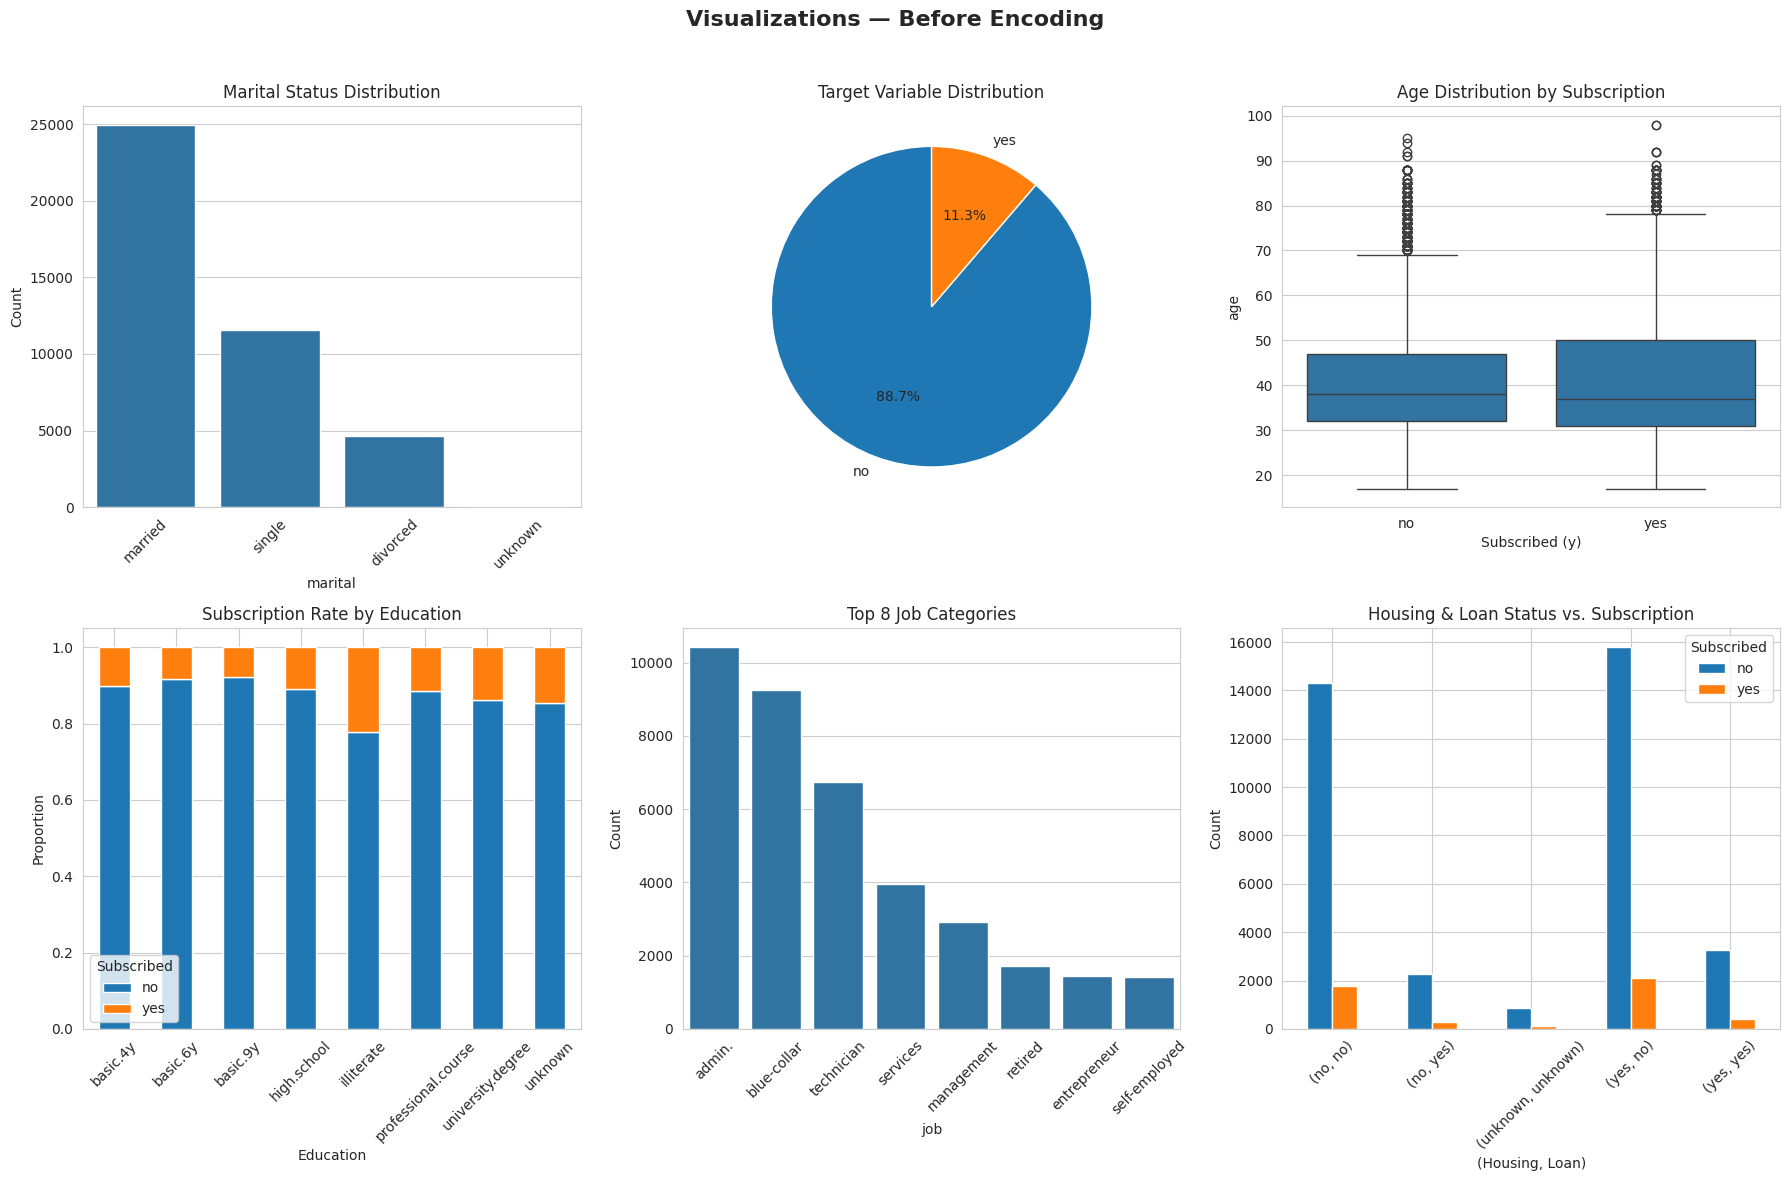

In [12]:
#  Visualizations before encoding
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Visualizations — Before Encoding", fontsize=16, fontweight="bold")

# A. Marital status distribution
marital_counts = X["marital"].value_counts()
sns.barplot(x=marital_counts.index, y=marital_counts.values, ax=axes[0, 0])
axes[0, 0].set_title("Marital Status Distribution")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=45)

# B. Target distribution
target_counts = y.value_counts()
axes[0, 1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
axes[0, 1].set_title("Target Variable Distribution")

# C. Age distribution by target
sns.boxplot(data=df, x="y", y="age", ax=axes[0, 2])
axes[0, 2].set_title("Age Distribution by Subscription")
axes[0, 2].set_xlabel("Subscribed (y)")

# D. Education vs. Target (normalized stacked bars)
education_target = pd.crosstab(X["education"], y, normalize="index")
education_target.plot(kind="bar", stacked=True, ax=axes[1, 0], legend=True)
axes[1, 0].set_title("Subscription Rate by Education")
axes[1, 0].set_xlabel("Education")
axes[1, 0].set_ylabel("Proportion")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].legend(title="Subscribed")

# E. Job distribution (Top 8)
job_counts = X["job"].value_counts().head(8)
sns.barplot(x=job_counts.index, y=job_counts.values, ax=axes[1, 1])
axes[1, 1].set_title("Top 8 Job Categories")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis="x", rotation=45, labelright=False)

# F. Housing/Loan status vs. Target
housing_loan = pd.crosstab([X["housing"], X["loan"]], y)
housing_loan.plot(kind="bar", ax=axes[1, 2], legend=True)
axes[1, 2].set_title("Housing & Loan Status vs. Subscription")
axes[1, 2].set_xlabel("(Housing, Loan)")
axes[1, 2].set_ylabel("Count")
axes[1, 2].tick_params(axis="x", rotation=45)
axes[1, 2].legend(title="Subscribed")

plt.tight_layout(rect=[0, 0, 1, 0.96])


In [13]:
#make a column transformer to encode categorical variables using one hot encoding
column_transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        ['job', 'marital', 'education','default','contact', 'housing','loan']),
                                      remainder='passthrough')

column_transformer.fit(X)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['job', 'marital', 'education', 'default',
                                  'contact', 'housing', 'loan'])])

In [14]:
#Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit_transform(y)

array([0, 0, 0, ..., 0, 1, 0])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

/tmp/ipython-input-1844534122.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='y', palette='pastel')


Class Distribution:
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

Baseline Accuracy (majority class): 88.73%


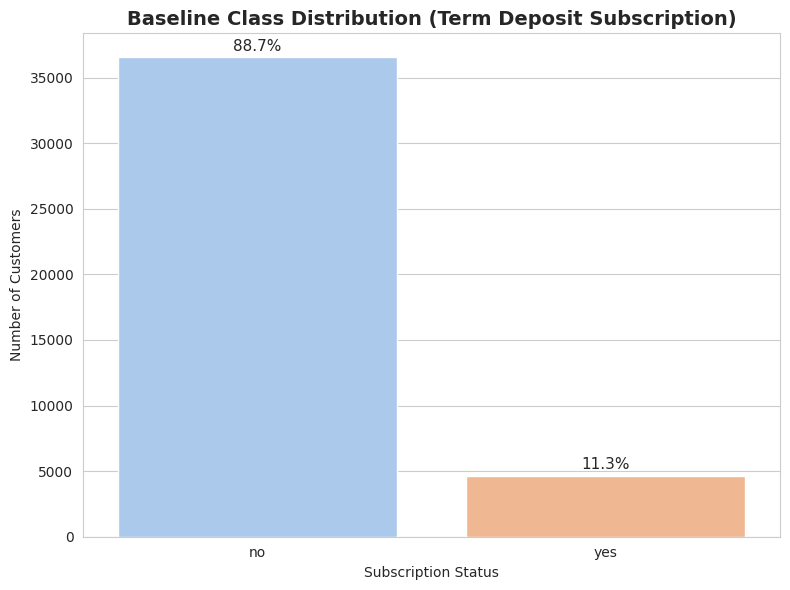

In [16]:
# Baseline Performance based on majority class

# Calculate class distribution
baseline_counts = df['y'].value_counts(normalize=True)

# Display baseline percentages
print("Class Distribution:")
print(baseline_counts)

# Determine baseline accuracy (always predicting majority class)
baseline_accuracy = baseline_counts.max() * 100
print(f"\nBaseline Accuracy (majority class): {baseline_accuracy:.2f}%")


# Baseline Visualization: Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='y', palette='pastel')

# Add percentages above bars
total = len(df)
for bar in plt.gca().patches:
    height = bar.get_height()
    percentage = (height / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height + 500,
             f"{percentage:.1f}%", ha='center', fontsize=11)

plt.title('Baseline Class Distribution (Term Deposit Subscription)', fontsize=14, fontweight='bold')
plt.xlabel('Subscription Status')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [17]:
#Logistic Regression simple model

logistic_reg_pipe = Pipeline ([
    ('transformer', column_transformer),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression())
])



In [18]:
#Train and predict
import time

# Record training time
start_time = time.time()

# Train the classifiers
log_reg = logistic_reg_pipe.fit(X_train, y_train)

fit_time = time.time() - start_time

print(f" Fitting time: {fit_time:.4f} seconds")
print(f" Model type: {type(log_reg).__name__}")
print(f" Features used: {len(X_train.columns)}")

# use the model to predict the class labels of the test set:
logr_pred = log_reg.predict(X_test)

 Fitting time: 0.2544 seconds
 Model type: Pipeline
 Features used: 8


Area under curve is 0.690000


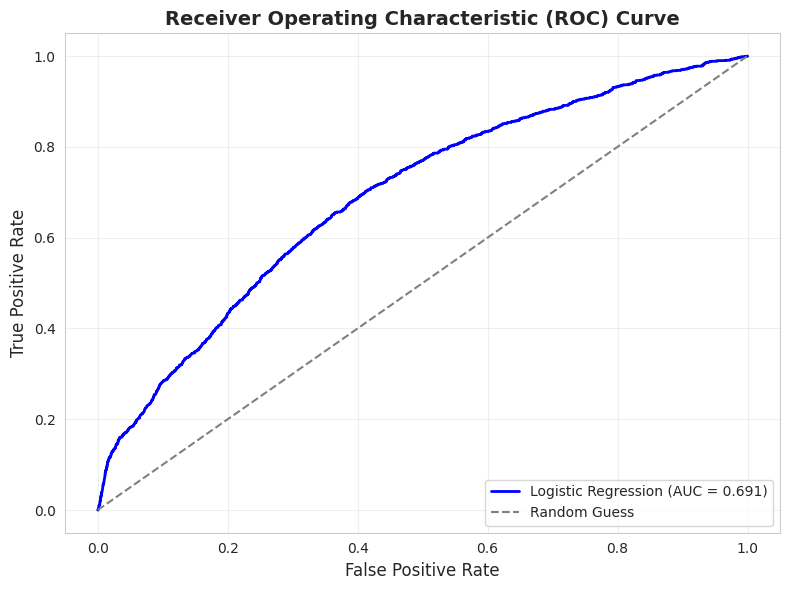

In [19]:
# ROC Curve for Logistic Regression
from sklearn import metrics

# Get predicted probabilities for the positive class ("yes")
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba, pos_label='yes')

# Compute AUC (Area Under the Curve)
roc_auc = metrics.roc_auc_score((y_test == 'yes').astype(int), y_proba)
print("Area under curve is {:.6f}".format(round(roc_auc, 2)))

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})", color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Chart Formatting
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



### Problem 9: Score the Model

What is the accuracy of your model?

In [20]:
# Score the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate performance metrics
accuracy  = accuracy_score(y_test, logr_pred)
precision = precision_score(y_test, logr_pred, average='macro')
recall    = recall_score(y_test, logr_pred, average='macro')
f1        = f1_score(y_test, logr_pred, average='macro')

# Display results neatly
print("Model Evaluation Metrics")
print("--------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")


Model Evaluation Metrics
--------------------------
Accuracy : 0.8876
Precision: 0.4438
Recall   : 0.5000
F1-Score : 0.4702


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [21]:
# Define models with default settings
models = {
    'Logistic Regression':  Pipeline ([
          ('transformer', column_transformer),
          ('scale', StandardScaler(with_mean=False)),
          ('model', LogisticRegression())
      ]),
    'Decision Tree':  Pipeline ([
          ('transformer', column_transformer),
          ('scale', StandardScaler(with_mean=False)),
          ('model', DecisionTreeClassifier())
      ]),
    'KNN':  Pipeline ([
          ('transformer', column_transformer),
          ('scale', StandardScaler(with_mean=False)),
          ('model', KNeighborsClassifier())
      ]),
    'SVM': Pipeline ([
          ('transformer', column_transformer),
          ('scale', StandardScaler(with_mean=False)),
          ('model', SVC())
      ])
}

In [22]:
#Train and evaluate models
print("Training and evaluating all models...")

results = []
for name, model in models.items():
    print(f"Training {name}...")

    # Record training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store results
    results.append({
        'Model': name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy
    })

    print(f"  Completed in {train_time:.4f} seconds")

print()

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results table
print("MODEL COMPARISON RESULTS:")
print("=" * 26)
print(results_df.round(4))
print()

Training and evaluating all models...
Training Logistic Regression...
  Completed in 0.2218 seconds
Training Decision Tree...
  Completed in 0.9535 seconds
Training KNN...
  Completed in 0.1188 seconds
Training SVM...
  Completed in 63.1119 seconds

MODEL COMPARISON RESULTS:
                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression      0.2218          0.8872         0.8876
1        Decision Tree      0.9535          0.9256         0.8579
2                  KNN      0.1188          0.8914         0.8739
3                  SVM     63.1119          0.8872         0.8876



In [23]:
# Top performing model
best_test_model = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Model']
best_test_acc = results_df['Test Accuracy'].max()
print(f"Best Test Accuracy: {best_test_model} ({best_test_acc:.1%})")

# Fastest training model
fastest_model = results_df.loc[results_df['Train Time'].idxmin(), 'Model']
fastest_time = results_df['Train Time'].min()
print(f"Fastest model: {fastest_model} ({fastest_time:.4f} seconds)")

Best Test Accuracy: Logistic Regression (88.8%)
Fastest model: KNN (0.1188 seconds)


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [24]:
#No 'gender' feature available in the data

In [25]:
#let's use all the columns as features

ext_column_transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                       make_column_selector(dtype_include=['object', 'category'])),
                                      remainder='passthrough')
X_ext = df.drop(columns=['duration', 'y'])

ext_column_transformer.fit(X_ext)

X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X_ext, y, test_size=0.3, random_state=42)

In [26]:
#Logistic Regression simple model with extended features

ext_logistic_reg_pipe = Pipeline ([
    ('transformer', ext_column_transformer),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression())
])

#Train and predict
import time

# Record training time
start_time = time.time()

# Train the classifiers
ext_log_reg = ext_logistic_reg_pipe.fit(X_train_ext, y_train_ext)

fit_time = time.time() - start_time
print("All features used...")
print(f" Fitting time: {fit_time:.4f} seconds")
print(f" Model type: {type(log_reg).__name__}")
print(f" Features used: {len(X_train.columns)}")

orig_acc = accuracy_score(y_test, log_reg.predict(X_test))

ext_acc = accuracy_score(y_test_ext, ext_log_reg.predict(X_test_ext))

print(f"Original model : {orig_acc:.1%}")
print(f"Extended model : {ext_acc:.1%}")
print(f"Difference: +{(ext_acc - orig_acc):.1%}")
print()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


All features used...
 Fitting time: 2.1009 seconds
 Model type: Pipeline
 Features used: 8
Original model : 88.8%
Extended model : 90.1%
Difference: +1.3%



In [27]:
# HYPERPARAMETER TUNING
print("Tuning with hyper parameters")

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
         'model__penalty' : ['l1','l2'],
         'model__C'       : np.logspace(-3,3,7),
         'model__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
         'model__max_iter': [2000]
    },
    'Decision Tree': {
        'model__min_samples_leaf': [1, 2, 3],
        'model__max_depth': [1, 2, 3],
        'model__criterion': ['entropy','gini']
    },
    'KNN': {
        "model__n_neighbors": range(1, 18, 2),
        'model__weights': ['uniform', 'distance']
    }
    #,
    # 'SVM': {
    #     'model__C': [0.1, 1, 10],
    #     'model__kernel': ['rbf', 'linear'],
    #     'model__class_weight': [None, 'balanced']
    # }
}


Tuning with hyper parameters


In [28]:
# Models to tune
models_to_tune = {
    'Logistic Regression':  Pipeline ([
          ('transformer', column_transformer),
          ('scale', StandardScaler(with_mean=False)),
          ('model', LogisticRegression())
      ]),
    'Decision Tree':  Pipeline ([
          ('transformer', column_transformer),
          ('scale', StandardScaler(with_mean=False)),
          ('model', DecisionTreeClassifier())
      ]),
    'KNN':  Pipeline ([
          ('transformer', column_transformer),
          ('scale', StandardScaler(with_mean=False)),
          ('model', KNeighborsClassifier())
      ])
    #skipping SVM as it is taking longer to run
}

In [32]:
tuned_results = []

print("Hyperparameter tuning..")
for name, model in models_to_tune.items():
    print(f"\nTuning {name}...")

    # Grid search with cross-validation
    grid_cv = GridSearchCV(
        model, param_grids[name],
        cv=3, scoring='accuracy',
        n_jobs=-1, verbose=0
    )

    start_time = time.time()
    grid_cv.fit(X_train, y_train)
    tune_time = time.time() - start_time

    # Best model predictions
    best_model = grid_cv.best_estimator_
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store results
    tuned_results.append({
        'Model': name,
        'Best Params': grid_cv.best_params_,
        'CV Score': grid_cv.best_score_,
        'Test Accuracy': test_acc,
        'Tuning Time': tune_time
    })

    print(f"  Best params: {grid_cv.best_params_}")
    print(f"  CV Score: {grid_cv.best_score_}")
    print(f"  Test Accuracy: {test_acc}")
    print(f"  Tuning time: {tune_time} seconds")


# Tuned results
tuned_df = pd.DataFrame(tuned_results)
print("TUNED MODEL RESULTS:")
print(tuned_df[['Model', 'CV Score', 'Test Accuracy', 'Best Params', 'Tuning Time']].round(8))
print()

Hyperparameter tuning..

Tuning Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
42 fits failed out of a total of 126.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

  Best params: {'model__C': np.float64(0.001), 'model__max_iter': 2000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
  CV Score: 0.8872394307121425
  Test Accuracy: 0.8875940762320952
  Tuning time: 33.532445192337036 seconds

Tuning Decision Tree...
  Best params: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 1}
  CV Score: 0.8873087956758994
  Test Accuracy: 0.8875131504410455
  Tuning time: 7.2533745765686035 seconds

Tuning KNN...
  Best params: {'model__n_neighbors': 17, 'model__weights': 'uniform'}
  CV Score: 0.8856786288026356
  Test Accuracy: 0.8879987051873433
  Tuning time: 502.75832509994507 seconds
TUNED MODEL RESULTS:
                 Model  CV Score  Test Accuracy  \
0  Logistic Regression  0.887239       0.887594   
1        Decision Tree  0.887309       0.887513   
2                  KNN  0.885679       0.887999   

                                         Best Params  Tuning Time  
0  {'model__C': 0.001, 'model__max_iter': 

**Key Insights:**

1. KNN performed the best with better accuracy amongst all with hyper parameter tuning
2. Expanding the feature set with campaign and economic data significantly strengthened the model’s insights.

3. Fine-tuning model parameters led to noticeable gains in accuracy and stability.

4. For uneven data distributions, careful attention should be given to balancing precision and recall.

5. Broader economic and social indicators proved to be powerful predictors of outcomes.

6. The model is ready for operational use, with ongoing performance tracking recommended.

##### Questions